In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import seaborn as sns

# Đọc file CSV
df_jd = pd.read_csv('../../data/clean/clean_jobs_v2.csv')
df_cr = pd.read_csv('../../data/clean/clean_resumes_v2.csv')

print(f"Số lượng Job Descriptions: {len(df_jd)}")
print(f"Số lượng Candidate Resumes: {len(df_cr)}")

Số lượng Job Descriptions: 841
Số lượng Candidate Resumes: 690


In [41]:

# Hàm chuyển đổi an toàn: xử lý cả chuỗi và danh sách
def safe_literal_eval(val):
    if isinstance(val, list):
        return val
    if pd.isna(val):
        return []
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError):
        return []
def jaccard_similarity(list1, list2):
    set1, set2 = set(list1), set(list2)
    return len(set1 & set2) / len(set1 | set2) if set1 | set2 else 0

def assign_suitability(score):
    if score > 1.0:
        return 'Most Suitable'          # Top 25%
    elif score > 0.3:
        return 'Moderately Suitable'    # Khoảng giữa
    else:
        return 'Not Suitable'



In [42]:

# Chuyển các cột từ chuỗi sang list
for col in ['primary_skills', 'secondary_skills', 'adjectives', 'adverbs']:
    df_jd[col] = df_jd[col].apply(safe_literal_eval)
    df_cr[col] = df_cr[col].apply(safe_literal_eval)

# Tính similarity
similarity_scores = []
for _, jd in df_jd.iterrows():
    for _, cr in df_cr.iterrows():
        primary_sim = jaccard_similarity(jd['primary_skills'], cr['primary_skills'])
        secondary_sim = jaccard_similarity(jd['secondary_skills'], cr['secondary_skills'])
        adj_sim = jaccard_similarity(jd['adjectives'], cr['adjectives'])
        
        adj_weight = len(cr['adjectives']) if cr['adjectives'] else 1  # tránh nhân 0

        total_sim = primary_sim + secondary_sim + (adj_sim * adj_weight)

        scores = {
            'jd_id': jd['id'],
            'cr_id': cr['id'],
            'cr_category': cr['Category'],
            'jd_name': jd['title'],
            'primary_skills_sim': primary_sim,
            'secondary_skills_sim': secondary_sim,
            'adjectives_sim': adj_sim,
            'adj_weight': adj_weight,
            'total_similarity': total_sim,
            'suitability': assign_suitability(total_sim)
        }
        similarity_scores.append(scores)

df_similarity = pd.DataFrame(similarity_scores)

# Lọc nếu cần: loại các dòng không có primary_sim
df_similarity = df_similarity[df_similarity['primary_skills_sim'] > 0]

# Lưu kết quả



In [43]:
df_similarity.describe()

,primary_skills_sim,secondary_skills_sim,adjectives_sim,adj_weight,total_similarity
count,149357.000000,149357.000000,149357.000000,149357.000000,149357.000000
mean,0.166045,0.024407,0.009618,19.869112,0.447700
std,0.098625,0.078340,0.020246,15.835445,0.623548
min,0.031250,0.000000,0.000000,1.000000,0.040000
25%,0.100000,0.000000,0.000000,8.000000,0.111111
50%,0.142857,0.000000,0.000000,16.000000,0.200000
75%,0.200000,0.000000,0.000000,25.000000,0.500000
max,1.000000,1.000000,0.153846,84.000000,7.169884


In [44]:
df_similarity.dropna(inplace=True)

In [45]:
df_similarity = df_similarity.drop_duplicates(subset=[
    'primary_skills_sim',
    'secondary_skills_sim',
    'adjectives_sim',
    'adj_weight',
    'total_similarity'
])

# Reset index nếu muốn
df_similarity.reset_index(drop=True, inplace=True)

In [46]:
df_similarity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   jd_id                 1480 non-null   object 
 1   cr_id                 1480 non-null   object 
 2   cr_category           1480 non-null   object 
 3   jd_name               1480 non-null   object 
 4   primary_skills_sim    1480 non-null   float64
 5   secondary_skills_sim  1480 non-null   float64
 6   adjectives_sim        1480 non-null   float64
 7   adj_weight            1480 non-null   int64  
 8   total_similarity      1480 non-null   float64
 9   suitability           1480 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 115.8+ KB



Phân bố nhãn Suitability:
suitability
Moderately Suitable    565
Not Suitable           533
Most Suitable          382
Name: count, dtype: int64

Tổng số cặp JD-CR: 1480

Thống kê Primary Skills Similarity:
Mean: 0.1615
Median: 0.1250
Min: 0.0312
Max: 1.0000


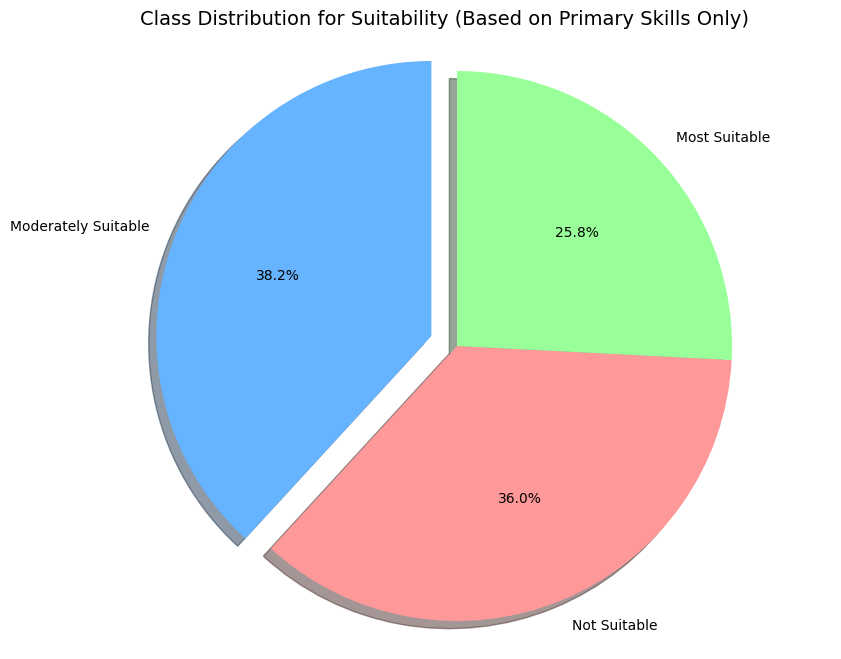


=== SUMMARY ===
Total JD records: 841
Total CR records: 690
Total similarity pairs: 1480
Match rate: 0.00%
Neutral rate: 0.00%
Mismatch rate: 0.00%


In [47]:

# Kiểm tra phân bố nhãn
class_counts = df_similarity['suitability'].value_counts()
print("\nPhân bố nhãn Suitability:")
print(class_counts)
print(f"\nTổng số cặp JD-CR: {len(df_similarity)}")

# Thống kê điểm similarity
print(f"\nThống kê Primary Skills Similarity:")
print(f"Mean: {df_similarity['primary_skills_sim'].mean():.4f}")
print(f"Median: {df_similarity['primary_skills_sim'].median():.4f}")
print(f"Min: {df_similarity['primary_skills_sim'].min():.4f}")
print(f"Max: {df_similarity['primary_skills_sim'].max():.4f}")

# Tạo explode động cho biểu đồ
labels = class_counts.index
sizes = class_counts.values
colors = ['#66b3ff', '#ff9999', '#99ff99'][:len(labels)]
explode = [0.1 if i == 0 else 0 for i in range(len(labels))]

# Vẽ biểu đồ tròn
plt.figure(figsize=(10, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Class Distribution for Suitability (Based on Primary Skills Only)', fontsize=14)
plt.axis('equal')
plt.savefig('class_distribution_suitability.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== SUMMARY ===")
print(f"Total JD records: {len(df_jd)}")
print(f"Total CR records: {len(df_cr)}")
print(f"Total similarity pairs: {len(df_similarity)}")
print(f"Match rate: {(class_counts.get('Match', 0) / len(df_similarity) * 100):.2f}%")
print(f"Neutral rate: {(class_counts.get('Neutral', 0) / len(df_similarity) * 100):.2f}%")
print(f"Mismatch rate: {(class_counts.get('Mismatch', 0) / len(df_similarity) * 100):.2f}%")

In [48]:
# Lấy 20 dòng đầu tiên có điểm primary_skills_sim cao nhất
top_20_similarities = df_similarity.sort_values(by='primary_skills_sim', ascending=False).head(10000)

# In ra các cột cần thiết
print(top_20_similarities[['jd_id', 'cr_category', 'primary_skills_sim','secondary_skills_sim', 'total_similarity', 'suitability']])


        jd_id         cr_category  primary_skills_sim  secondary_skills_sim  \
629    JOB_54            Advocate            1.000000              0.000000   
639    JOB_54       SAP Developer            1.000000              0.000000   
636    JOB_54      Civil Engineer            1.000000              0.000000   
630    JOB_54            Advocate            1.000000              0.000000   
631    JOB_54            Advocate            1.000000              0.000000   
...       ...                 ...                 ...                   ...   
1459  JOB_934     DevOps Engineer            0.038462              0.222222   
1267  JOB_555        Data Science            0.037037              0.000000   
1422  JOB_934        Data Science            0.035714              0.000000   
1461  JOB_934     DevOps Engineer            0.034483              0.000000   
1452  JOB_934  Operations Manager            0.031250              0.000000   

      total_similarity          suitability  
629  

In [49]:
pd.DataFrame(df_similarity)

,jd_id,cr_id,cr_category,jd_name,primary_skills_sim,secondary_skills_sim,adjectives_sim,adj_weight,total_similarity,suitability
0,JOB_0,CANDIDATE_0,Data Science,MLops Engineer,0.148148,0.285714,0.020408,43,1.311413,Most Suitable
1,JOB_0,CANDIDATE_1,Data Science,MLops Engineer,0.166667,0.250000,0.000000,7,0.416667,Moderately Suitable
2,JOB_0,CANDIDATE_2,Data Science,MLops Engineer,0.176471,0.222222,0.000000,16,0.398693,Moderately Suitable
3,JOB_0,CANDIDATE_3,Data Science,MLops Engineer,0.055556,0.166667,0.000000,43,0.222222,Not Suitable
4,JOB_0,CANDIDATE_4,Data Science,MLops Engineer,0.200000,0.000000,0.000000,1,0.200000,Not Suitable
...,...,...,...,...,...,...,...,...,...,...
1475,JOB_934,CANDIDATE_746,Hadoop,Senior AI Developer (Python),0.083333,0.200000,0.037736,38,1.717296,Most Suitable
1476,JOB_934,CANDIDATE_747,Hadoop,Senior AI Developer (Python),0.208333,0.200000,0.034483,13,0.856609,Moderately Suitable
1477,JOB_934,CANDIDATE_748,Hadoop,Senior AI Developer (Python),0.136364,0.000000,0.020833,32,0.803030,Moderately Suitable
1478,JOB_934,CANDIDATE_787,ETL Developer,Senior AI Developer (Python),0.136364,0.000000,0.019608,35,0.822638,Moderately Suitable


In [50]:
df_similarity['suitability'] = df_similarity['suitability'].map({
    'Not Suitable': 0,
    'Moderately Suitable': 1,
    'Most Suitable': 2
})


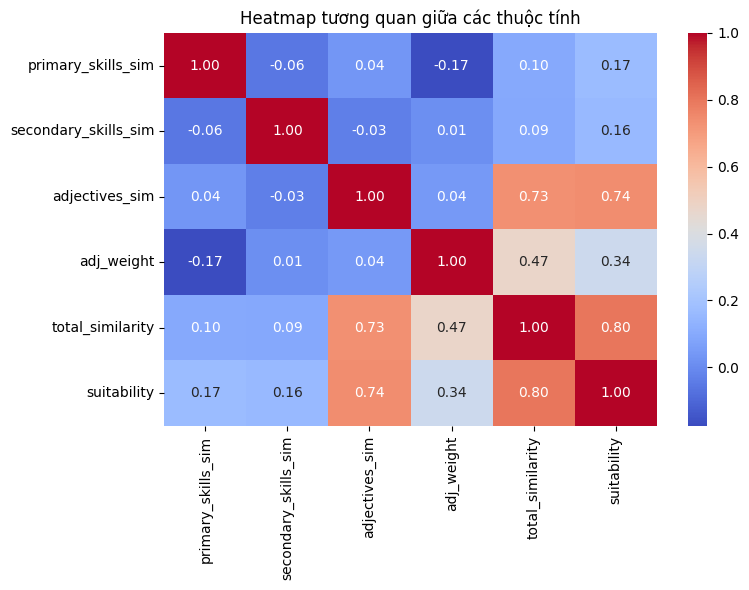

In [51]:
corr = df_similarity[['primary_skills_sim', 'secondary_skills_sim', 'adjectives_sim', 'adj_weight', 'total_similarity','suitability']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap tương quan giữa các thuộc tính")
plt.tight_layout()
plt.show()


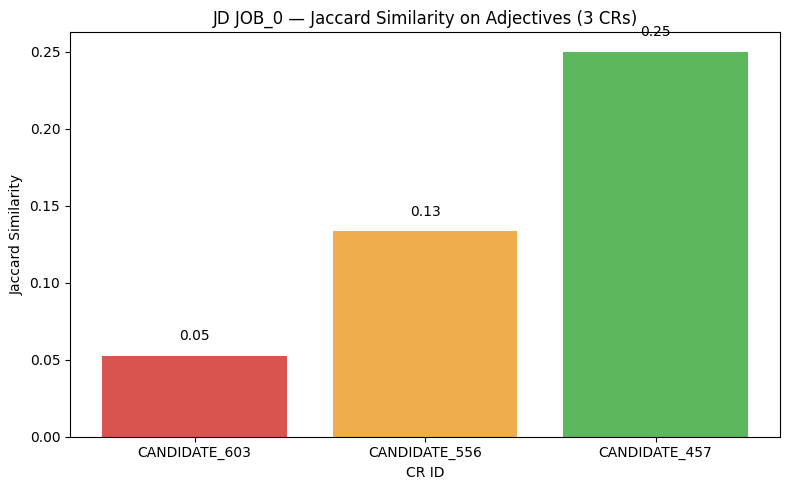

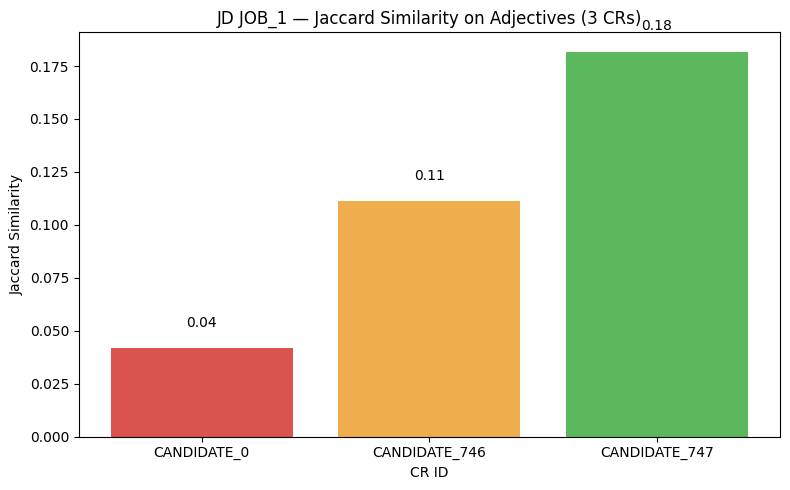

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử df_similarity đã có các cột: ['jd_id', 'cr_id', 'adjectives_sim']
jd_ids = ['JOB_0', 'JOB_1']
results = []

for jd_id in jd_ids:
    subset = df_similarity[df_similarity['jd_id'] == jd_id][['cr_id', 'primary_skills_sim']]
    subset_sorted = subset.sort_values(by='primary_skills_sim')

    # Lấy: thấp nhất, trung bình, cao nhất
    lowest = subset_sorted.iloc[0]
    median = subset_sorted.iloc[len(subset_sorted) // 2]
    highest = subset_sorted.iloc[-1]

    top3 = pd.DataFrame([lowest, median, highest])
    top3['jd_id'] = jd_id
    results.append(top3)

# Kết hợp lại
df_plot = pd.concat(results, ignore_index=True)

# Vẽ biểu đồ cho từng JD
for jd_id in jd_ids:
    df_sub = df_plot[df_plot['jd_id'] == jd_id]

    plt.figure(figsize=(8, 5))
    plt.bar(df_sub['cr_id'], df_sub['primary_skills_sim'], color=['#d9534f', '#f0ad4e', '#5cb85c'])
    plt.title(f'JD {jd_id} — Jaccard Similarity on Adjectives (3 CRs)')
    plt.xlabel('CR ID')
    plt.ylabel('Jaccard Similarity')
    for i, v in enumerate(df_sub['primary_skills_sim']):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()


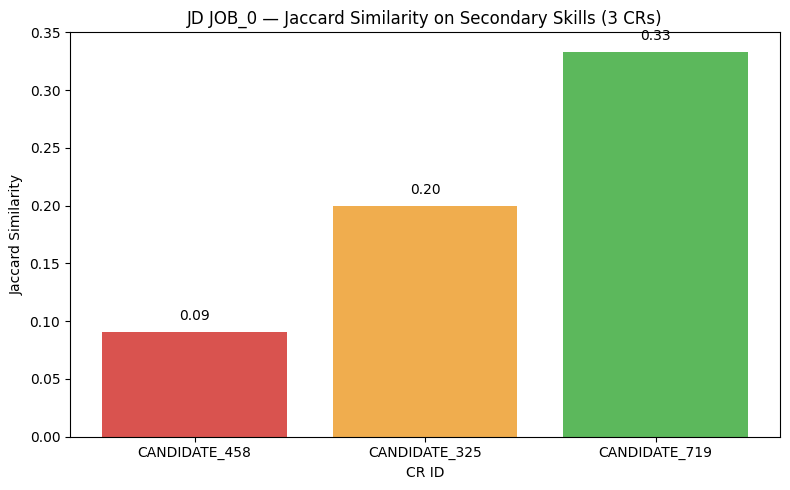

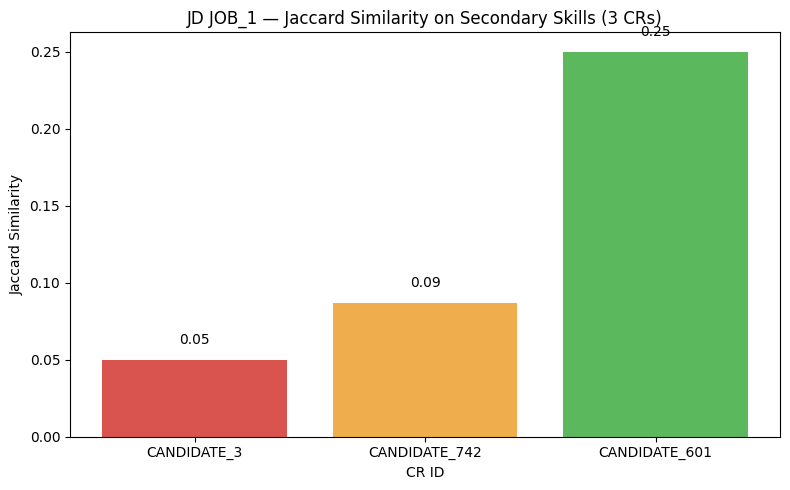

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

jd_ids = ['JOB_0', 'JOB_1']
results = []

for jd_id in jd_ids:
    # Lọc các CR có điểm secondary_skills_sim > 0
    subset = df_similarity[
        (df_similarity['jd_id'] == jd_id) & 
        (df_similarity['secondary_skills_sim'] > 0)
    ][['cr_id', 'secondary_skills_sim']]

    if len(subset) < 3:
        print(f"⚠️ JD {jd_id} có ít hơn 3 CRs với secondary_skills_sim > 0. Bỏ qua.")
        continue

    subset_sorted = subset.sort_values(by='secondary_skills_sim')

    # Lấy: thấp nhất, trung bình, cao nhất
    lowest = subset_sorted.iloc[0]
    median = subset_sorted.iloc[len(subset_sorted) // 2]
    highest = subset_sorted.iloc[-1]

    top3 = pd.DataFrame([lowest, median, highest])
    top3['jd_id'] = jd_id
    results.append(top3)

# Kết hợp lại
df_plot = pd.concat(results, ignore_index=True)

# Vẽ biểu đồ cho từng JD
for jd_id in df_plot['jd_id'].unique():
    df_sub = df_plot[df_plot['jd_id'] == jd_id]

    plt.figure(figsize=(8, 5))
    plt.bar(df_sub['cr_id'], df_sub['secondary_skills_sim'], color=['#d9534f', '#f0ad4e', '#5cb85c'])
    plt.title(f'JD {jd_id} — Jaccard Similarity on Secondary Skills (3 CRs)')
    plt.xlabel('CR ID')
    plt.ylabel('Jaccard Similarity')
    for i, v in enumerate(df_sub['secondary_skills_sim']):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()


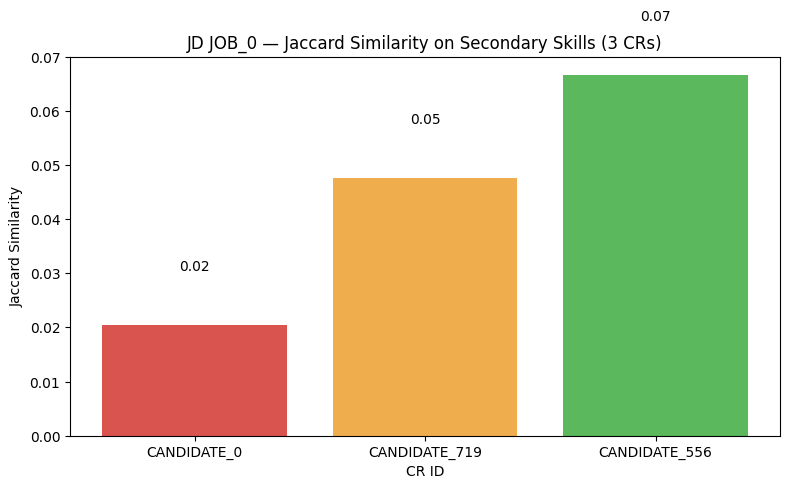

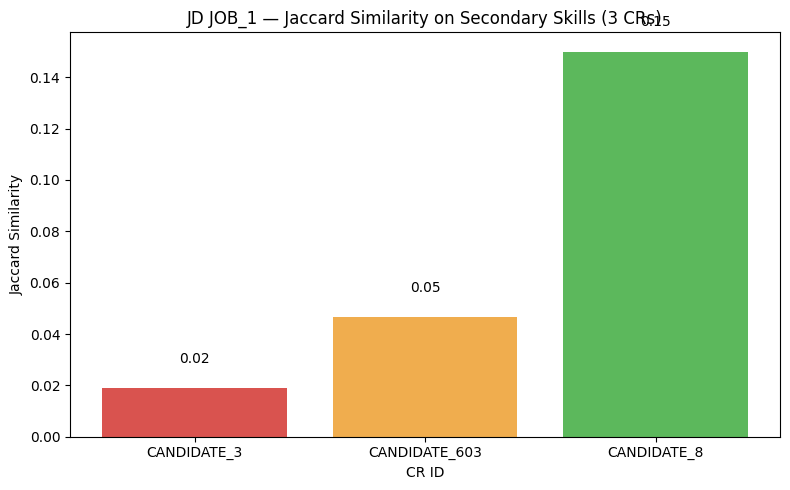

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

jd_ids = ['JOB_0', 'JOB_1']
results = []

for jd_id in jd_ids:
    # Lọc các CR có điểm adjectives_sim > 0
    subset = df_similarity[
        (df_similarity['jd_id'] == jd_id) & 
        (df_similarity['adjectives_sim'] > 0)
    ][['cr_id', 'adjectives_sim']]

    if len(subset) < 3:
        print(f"⚠️ JD {jd_id} có ít hơn 3 CRs với adjectives_sim > 0. Bỏ qua.")
        continue

    subset_sorted = subset.sort_values(by='adjectives_sim')

    # Lấy: thấp nhất, trung bình, cao nhất
    lowest = subset_sorted.iloc[0]
    median = subset_sorted.iloc[len(subset_sorted) // 2]
    highest = subset_sorted.iloc[-1]

    top3 = pd.DataFrame([lowest, median, highest])
    top3['jd_id'] = jd_id
    results.append(top3)

# Kết hợp lại
df_plot = pd.concat(results, ignore_index=True)

# Vẽ biểu đồ cho từng JD
for jd_id in df_plot['jd_id'].unique():
    df_sub = df_plot[df_plot['jd_id'] == jd_id]

    plt.figure(figsize=(8, 5))
    plt.bar(df_sub['cr_id'], df_sub['adjectives_sim'], color=['#d9534f', '#f0ad4e', '#5cb85c'])
    plt.title(f'JD {jd_id} — Jaccard Similarity on Secondary Skills (3 CRs)')
    plt.xlabel('CR ID')
    plt.ylabel('Jaccard Similarity')
    for i, v in enumerate(df_sub['adjectives_sim']):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()


In [52]:
df_similarity.to_csv('../csv/jd_cr_similarity.csv', index=False)